# OZONE TROPOSPHERIC (O3) - Tropospheric = ground-level ozone

In [175]:
%%capture
!pip install xarray==0.20.2  #latest package 2022.6.0 doesn't work
!pip install s3fs
!pip install netcdf4
!pip install h5netcdf

!pip install geopandas --quiet
!pip install shapely --quiet
!pip install contextily --quiet

In [176]:
import s3fs
import h5netcdf
import netCDF4
import xarray as xr

import pandas as pd
import numpy as np
import boto3
import matplotlib.pyplot as plt
import math

from shapely.geometry import Point, Polygon
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
import contextily as cx

### LOOP THROUGH FOLDERS AND EXTRACT DATA

### <font color='red'> TROPOSPHERIC 03 ONLY HAS 1 .NC FILE PER DAY </font>

In [192]:
one_to_nine = ['01', '02', '03', '04', '05', '06', '07', '08', '09']
ten_to_32 = list(range(10, 32))
for i in ten_to_32:
    i = str(i)
ten_to_32_str = [str(i) for i in ten_to_32]
subfolder_list = one_to_nine + ten_to_32_str
print(subfolder_list)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']


In [193]:
#reduce down to only looking at half a month
limit = math.ceil((len(subfolder_list)/2))
subfolder_list = subfolder_list[0:limit]
print(subfolder_list)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16']


In [194]:
indices = [5, 6, 7, 8]   #take only keys at these indices from each subfolder, where we know london coverage appears
keys = []
for i in subfolder_list:
    bucket = 'meeo-s5p'
    subfolder = 'OFFL/L2__O3____/2022/06/' + i + '/'   #loop through June's subfolders

    conn = boto3.client('s3')
    #some folders e.g. 10 don't exist, continue loop when error for these non existent folders
    try:
        contents = conn.list_objects(Bucket=bucket, Prefix=subfolder)['Contents']
    except:
        continue
    
    temp_list = []
    for f in contents:
        temp_list.append(f['Key'])
    
    for index in range(len(temp_list)):
        if index in indices:
            keys.append(temp_list[index])
            
keys[0:8]

['OFFL/L2__O3____/2022/06/01/S5P_OFFL_L2__O3_____20220601T085512_20220601T103642_24005_02_020300_20220603T081146.nc',
 'OFFL/L2__O3____/2022/06/01/S5P_OFFL_L2__O3_____20220601T103642_20220601T121812_24006_02_020300_20220603T081445.nc',
 'OFFL/L2__O3____/2022/06/01/S5P_OFFL_L2__O3_____20220601T121812_20220601T135942_24007_02_020300_20220603T042455.nc',
 'OFFL/L2__O3____/2022/06/01/S5P_OFFL_L2__O3_____20220601T135942_20220601T154112_24008_02_020300_20220603T055819.nc',
 'OFFL/L2__O3____/2022/06/02/S5P_OFFL_L2__O3_____20220602T083611_20220602T101741_24019_02_020300_20220604T003409.nc',
 'OFFL/L2__O3____/2022/06/02/S5P_OFFL_L2__O3_____20220602T101741_20220602T115911_24020_02_020300_20220604T023952.nc',
 'OFFL/L2__O3____/2022/06/02/S5P_OFFL_L2__O3_____20220602T115911_20220602T134041_24021_02_020300_20220604T041247.nc',
 'OFFL/L2__O3____/2022/06/02/S5P_OFFL_L2__O3_____20220602T134041_20220602T152211_24022_02_020300_20220604T053756.nc']

In [195]:
len(keys)

58

In [196]:
#find .nc file where filtering does not result in 0 longitude or latitudes (or co)

uk_keys = []
count = 0
uk_df = pd.DataFrame() 
for i in keys:
    #extract data from netcdf5 as xarray dataset
    fs = s3fs.S3FileSystem(anon=True)
    f = fs.open('s3://meeo-s5p/' + i)
    ds = xr.open_dataset(f, engine='h5netcdf', group = 'PRODUCT')

    #collapse 3 dimensions
    ds = ds.sel(time=ds.time[0])
    ds = ds.sel(layer=0)
    ds = ds.drop_dims('corner')
    ds = ds.drop_dims('level')
    #only high quality data
    #ds = ds.where(ds.qa_value > 0.5, drop = True)
    #target parameter
    ds = ds[['latitude', 'longitude', 'ozone_total_vertical_column', 'qa_value']]   #keep qa value too, can filter later if want
    #uk filter
    #ds = ds.where((ds.latitude > 50.10319) & (ds.latitude < 60.15456), drop = True)
    #ds = ds.where((ds.longitude > -7.64133) & (ds.longitude < 1.75159), drop = True)
    #london filter
    ds = ds.where((ds.latitude > 51.239405) & (ds.latitude < 51.737184), drop = True)
    ds = ds.where((ds.longitude > -0.625211) & (ds.longitude < 0.328289), drop = True)

    #drop nas along remaining dimensions - NO, for transparency of method, NAs will be dropped from dataframe than xarray
    #ds = ds.dropna('scanline', how='any')
    #ds = ds.dropna('ground_pixel', how='any')
    
    count += 1
    
    df = ds.to_dataframe()
    df = df.reset_index()
    df = df.drop(['scanline', 'ground_pixel'], axis = 1)
    df = df.dropna(how = 'any')
    
    if len(df) == 0:
        print(str(count) + '/' + str(len(keys)), '\t', '---> NONE FOUND')
        continue
    else:
        print(str(count) + '/' + str(len(keys)), '\t', '---> UK COVERAGE FOUND')
        #append to uk keys list
        uk_keys.append(i)
        #append to uk dataframe
        uk_df = uk_df.append(df)
        continue

1/58 	 ---> NONE FOUND
2/58 	 ---> UK COVERAGE FOUND
3/58 	 ---> UK COVERAGE FOUND
4/58 	 ---> NONE FOUND
5/58 	 ---> NONE FOUND
6/58 	 ---> NONE FOUND
7/58 	 ---> UK COVERAGE FOUND
8/58 	 ---> NONE FOUND
9/58 	 ---> NONE FOUND
10/58 	 ---> UK COVERAGE FOUND
11/58 	 ---> NONE FOUND
12/58 	 ---> NONE FOUND
13/58 	 ---> NONE FOUND
14/58 	 ---> UK COVERAGE FOUND
15/58 	 ---> UK COVERAGE FOUND
16/58 	 ---> NONE FOUND
17/58 	 ---> NONE FOUND
18/58 	 ---> UK COVERAGE FOUND
19/58 	 ---> UK COVERAGE FOUND
20/58 	 ---> NONE FOUND
21/58 	 ---> NONE FOUND
22/58 	 ---> UK COVERAGE FOUND
23/58 	 ---> UK COVERAGE FOUND
24/58 	 ---> NONE FOUND
25/58 	 ---> NONE FOUND
26/58 	 ---> UK COVERAGE FOUND
27/58 	 ---> UK COVERAGE FOUND
28/58 	 ---> NONE FOUND
29/58 	 ---> NONE FOUND
30/58 	 ---> UK COVERAGE FOUND
31/58 	 ---> NONE FOUND
32/58 	 ---> NONE FOUND
33/58 	 ---> UK COVERAGE FOUND
34/58 	 ---> UK COVERAGE FOUND
35/58 	 ---> UK COVERAGE FOUND
36/58 	 ---> UK COVERAGE FOUND
37/58 	 ---> NONE FOUND
38

In [197]:
uk_df.head()

,latitude,longitude,ozone_total_vertical_column,qa_value,time,layer
4,51.259598,0.292720,0.171370,1.0,2022-06-01,0
11,51.303303,0.252288,0.170824,1.0,2022-06-01,0
17,51.271698,0.059670,0.170934,1.0,2022-06-01,0
18,51.346848,0.211568,0.172827,1.0,2022-06-01,0
24,51.315163,0.018826,0.171842,1.0,2022-06-01,0


In [198]:
len(uk_df)

2666

In [199]:
#persist dataframe to local csv file        
uk_df.to_csv('o3_sentinel_01-16june.csv', index = False)

### MANUAL EDA OF DATA FOR METRIC (e.g. setup filters needed)

In [144]:
fs = s3fs.S3FileSystem(anon=True)

# Open with s3fs
#f = fs.open('s3://meeo-s5p/OFFL/L2__O3_TCL/2022/01/07/S5P_OFFL_L2__O3_TCL_20220107T110447_20220113T115047_21992_02_020201_20220122T000315.nc')   #O3_TCL
f = fs.open('s3://meeo-s5p/OFFL/L2__O3____/2022/01/01/S5P_OFFL_L2__O3_____20220101T105540_20220101T123710_21864_02_020201_20220103T031613.nc')   #O3

# open xarray dataset
ds2 = xr.open_dataset(f, engine='h5netcdf', group = 'PRODUCT')   #or netcdf4

In [145]:
ds5 = ds2.copy()

In [146]:
ds5

<xarray.Dataset>
Dimensions:                                (scanline: 4172, ground_pixel: 450, time: 1, corner: 4, layer: 14, level: 15)
Coordinates:
  * scanline                               (scanline) float64 0.0 ... 4.171e+03
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
  * time                                   (time) datetime64[ns] 2022-01-01
  * corner                                 (corner) float64 0.0 1.0 2.0 3.0
  * layer                                  (layer) int32 0 1 2 3 ... 10 11 12 13
  * level                                  (level) int32 0 1 2 3 ... 11 12 13 14
Data variables:
    latitude                               (time, scanline, ground_pixel) float32 ...
    longitude                              (time, scanline, ground_pixel) float32 ...
    delta_time                             (time, scanline, ground_pixel) datetime64[ns] ...
    time_utc                               (time, scanline) object ...
    qa_value                               (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column            (time, scanline, ground_pixel) float32 ...
    ozone_total_vertical_column_precision  (time, scanline, ground_pixel) float32 ...

In [147]:
print(ds5.latitude.size)
print(ds5.longitude.size)

1877400
1877400


In [148]:
#filtering to 1 time essentially drops time dimension
ds5 = ds5.sel(time=ds5.time[0])

In [149]:
print(ds5.latitude.size)
print(ds5.longitude.size)

1877400
1877400


In [150]:
ds5 = ds5.sel(layer=0)

In [151]:
print(ds5.latitude.size)
print(ds5.longitude.size)

1877400
1877400


In [152]:
#only need scanline and ground_pixel dimensions for lon lat and co (see brackets)
ds5 = ds5.drop_dims('corner')
ds5 = ds5.drop_dims('level')

In [153]:
print(ds5.latitude.size)
print(ds5.longitude.size)

1877400
1877400


In [154]:
ds5

<xarray.Dataset>
Dimensions:                                (scanline: 4172, ground_pixel: 450)
Coordinates:
  * scanline                               (scanline) float64 0.0 ... 4.171e+03
  * ground_pixel                           (ground_pixel) float64 0.0 ... 449.0
    time                                   datetime64[ns] 2022-01-01
    layer                                  int32 0
Data variables:
    latitude                               (scanline, ground_pixel) float32 ...
    longitude                              (scanline, ground_pixel) float32 ...
    delta_time                             (scanline, ground_pixel) datetime64[ns] ...
    time_utc                               (scanline) object nan nan ... nan nan
    qa_value                               (scanline, ground_pixel) float32 ...
    ozone_total_vertical_column            (scanline, ground_pixel) float32 ...
    ozone_total_vertical_column_precision  (scanline, ground_pixel) float32 ...

In [155]:
#Recommend to ignore data with qa_value < 0.5 --> from data variable descriptor
#ds5 = ds5.where(ds5.qa_value > 0.5, drop = True)

In [156]:
print(ds5.latitude.size)
ds5.longitude.size

1877400


1877400

In [157]:
#filter by qa value then by co column so that dropping NAs (afterwards) only occurs for co column (retain as much as possible)
ds5 = ds5[['latitude', 'longitude', 'ozone_total_vertical_column', 'qa_value']]

In [158]:
print(ds5.latitude.size)
ds5.longitude.size

1877400


1877400

In [159]:
#uk filter latitude, 500m is the lowest of the 50 layers
#ds5 = ds5.where((ds5.latitude > 50.10319) & (ds5.latitude < 60.15456), drop = True)
#ds5 = ds5.where((ds5.longitude > -7.64133) & (ds5.longitude < 1.75159), drop = True)

#london filter
ds5 = ds5.where((ds5.latitude > 51.239405) & (ds5.latitude < 51.737184), drop = True)
ds5 = ds5.where((ds5.longitude > -0.625211) & (ds5.longitude < 0.328289), drop = True)

In [160]:
print(ds5.latitude.size)
ds5.longitude.size

168


168

In [161]:
#BEST DROPPING NAS FROM DATAFRAME RATHER THAN XARRAY AS CLEARER WHATS BEING DONE

#drops NAs in this dimension
#will remove all NAs of co

#how ({"any", "all"}, default: "any") –
#any : if any NA values are present, drop that label
#all : if all values are NA, drop that label

#if any of longitude, latitude or co have null values, that data record becomes useless, so drop any

#ds5 = ds5.dropna('scanline', how='any')
#ds5 = ds5.dropna('ground_pixel', how='any')

In [162]:
ds5

<xarray.Dataset>
Dimensions:                      (scanline: 14, ground_pixel: 12)
Coordinates:
  * scanline                     (scanline) float64 3.609e+03 ... 3.622e+03
  * ground_pixel                 (ground_pixel) float64 74.0 75.0 ... 84.0 85.0
    time                         datetime64[ns] 2022-01-01
    layer                        int32 0
Data variables:
    latitude                     (scanline, ground_pixel) float32 nan ... nan
    longitude                    (scanline, ground_pixel) float32 nan ... nan
    ozone_total_vertical_column  (scanline, ground_pixel) float32 nan ... nan
    qa_value                     (scanline, ground_pixel) float32 nan ... nan

In [163]:
df = ds5.to_dataframe()

In [164]:
df.head()

latitude  longitude  ozone_total_vertical_column  \
scanline ground_pixel                                                     
3609.0   74.0               NaN        NaN                          NaN   
         75.0               NaN        NaN                          NaN   
         76.0               NaN        NaN                          NaN   
         77.0               NaN        NaN                          NaN   
         78.0               NaN        NaN                          NaN   

                       qa_value       time  layer  
scanline ground_pixel                              
3609.0   74.0               NaN 2022-01-01      0  
         75.0               NaN 2022-01-01      0  
         76.0               NaN 2022-01-01      0  
         77.0               NaN 2022-01-01      0  
         78.0               NaN 2022-01-01      0

In [165]:
len(df)

168

In [166]:
df = df.reset_index()

In [167]:
df.head()

,scanline,ground_pixel,latitude,longitude,ozone_total_vertical_column,qa_value,time,layer
0,3609.0,74.0,NaN,NaN,NaN,NaN,2022-01-01,0
1,3609.0,75.0,NaN,NaN,NaN,NaN,2022-01-01,0
2,3609.0,76.0,NaN,NaN,NaN,NaN,2022-01-01,0
3,3609.0,77.0,NaN,NaN,NaN,NaN,2022-01-01,0
4,3609.0,78.0,NaN,NaN,NaN,NaN,2022-01-01,0


In [168]:
df.columns

Index(['scanline', 'ground_pixel', 'latitude', 'longitude',
       'ozone_total_vertical_column', 'qa_value', 'time', 'layer'],
      dtype='object')

In [169]:
df = df.drop(['scanline', 'ground_pixel'], axis = 1)
df.head()

,latitude,longitude,ozone_total_vertical_column,qa_value,time,layer
0,NaN,NaN,NaN,NaN,2022-01-01,0
1,NaN,NaN,NaN,NaN,2022-01-01,0
2,NaN,NaN,NaN,NaN,2022-01-01,0
3,NaN,NaN,NaN,NaN,2022-01-01,0
4,NaN,NaN,NaN,NaN,2022-01-01,0


In [170]:
print('Number of NAs:', df['ozone_total_vertical_column'].isnull().sum())

Number of NAs: 68


In [171]:
df = df.dropna(how = 'any')

In [172]:
df.head()

,latitude,longitude,ozone_total_vertical_column,qa_value,time,layer
7,51.245838,0.211708,0.136788,0.9,2022-01-01,0
8,51.274513,0.290674,0.137211,0.9,2022-01-01,0
18,51.263016,0.099561,0.137605,0.8,2022-01-01,0
19,51.292065,0.179176,0.136609,1.0,2022-01-01,0
20,51.320759,0.258201,0.137778,0.9,2022-01-01,0


In [173]:
len(df)

100

In [174]:
df.duplicated().value_counts()

False    100
dtype: int64

### MAPPING LATITUDES AND LONGITUDES

In [200]:
df = uk_df

In [201]:
lalo_data = df[['longitude', 'latitude']]
lalo_data.head()

,longitude,latitude
4,0.292720,51.259598
11,0.252288,51.303303
17,0.059670,51.271698
18,0.211568,51.346848
24,0.018826,51.315163


In [202]:
london_map = gpd.read_file(r'London-wards-2018/London-wards-2018_ESRI/London_Ward_CityMerged.shp')

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(lalo_data, geometry = geometry, crs = 4326)
#4326 is the go to CRS for GPS lat lon, need to set here so conversion to another is standardised as setting wrong CRS here means conversion (to_crs) will be wrong

london_map['geometry'] = london_map['geometry'].to_crs(epsg=3857)
gdf['geometry'] = gdf['geometry'].to_crs(epsg=3857)

In [203]:
def makeLayeredMap(*args):
    """This function accepts an arbitrary number of geodataframes, plots them on top of a Contextily basemap. 
    NOTE: Please edit the Plotting-section to specify parameters for the number of layers and the formatting of each layer.
    Output: Saved file and layered map for display."""
    
    # Convert the CRS for all layers to EPSG3857 to match Contextily
    args = list(map(lambda x: x.to_crs(epsg=3857), args))
    # Create figure
    fig, ax = plt.subplots(1, figsize=(20, 20))
    #Set aspect to equal
    ax.set_aspect('equal')
    
    # PLOTTING: Specify layers to plot how to format each layer (colours, transparency, etc.):
    # Layer 1:
    args[0].boundary.plot(ax=ax, color='blue', edgecolor='k', alpha=0.3, zorder=1)
    # Layer 2:
    args[1].plot(ax=ax, color='red', markersize=400, marker='*', zorder=2)
    # ADD LAYERS here as needed:
    #args[2].plot(ax=ax, color='black', alpha=0.3, zorder=3)
    
    # Contextily basemap:
    cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
    
    # Turn off axis
    ax.axis('off')
    # Save as file
    fig.savefig('O3_sentinel_london_satellite.png', dpi=300)
    layered_map = plt.show()
    return(layered_map)
    #plt.show()

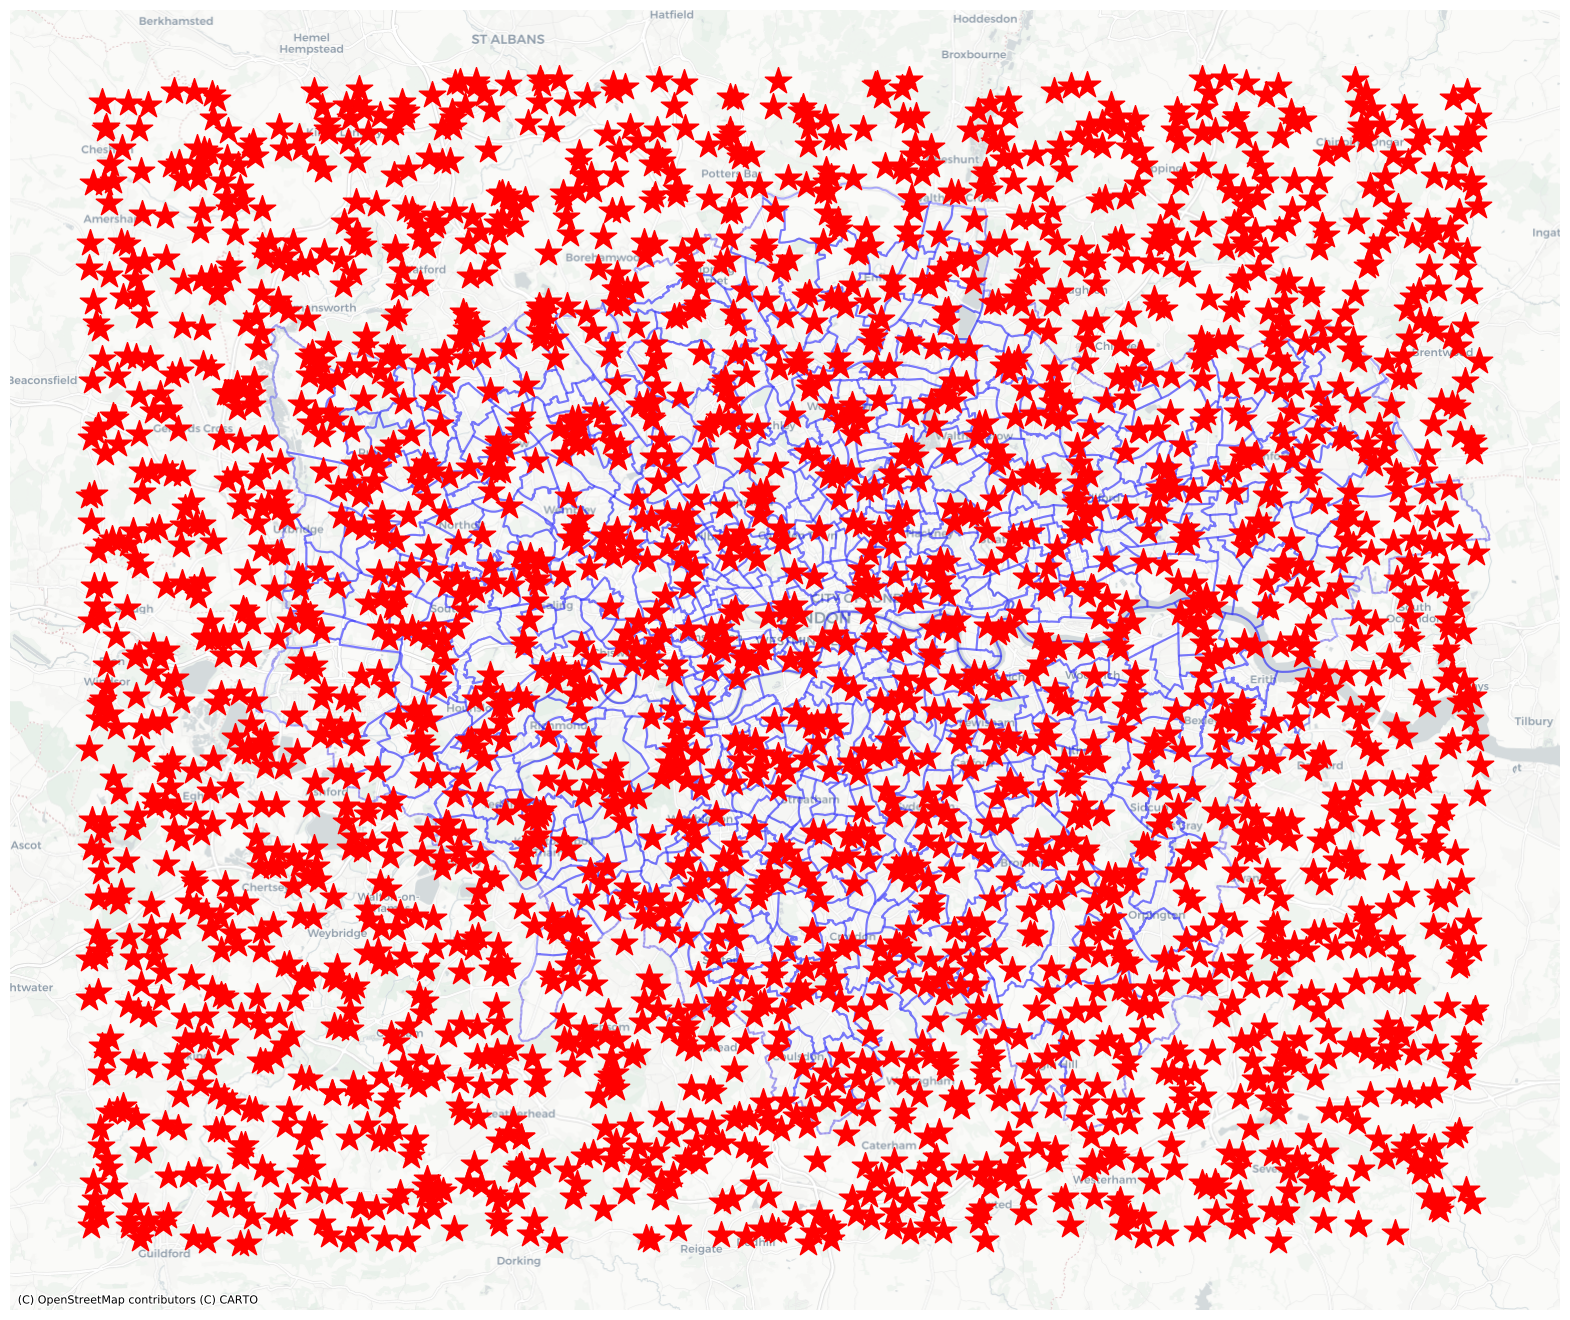

In [204]:
makeLayeredMap(london_map, gdf)